In [62]:
import spacy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout, Flatten, Embedding, TextVectorization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score
import scikitplot as skplt
import numpy as np
from tqdm.notebook import tqdm_notebook


# Read in preprocessed data

In [2]:
train_x = pd.read_csv('./x_train.csv')
train_y = pd.read_csv('./y_train.csv')
test_x = pd.read_csv('./x_test.csv')
test_y = pd.read_csv('./y_test.csv')

train_df = pd.concat([train_x, train_y], axis=1)
test_df = pd.concat([test_x, test_y], axis=1)

train_df = train_df[['text', 'label']]
test_df = test_df[['text', 'label']]

In [3]:
train_df

,text,label
0,bromwell high cartoon comedy ran time program ...,+
1,homelessness houselessness george carlin state...,+
2,brilliant overacting lesley ann warren best dr...,+
3,easily underrated film inn brook cannon sure f...,+
4,typical mel brook film much le slapstick movie...,+
...,...,...
24995,towards end movie felt technical felt like cla...,-
24996,kind movie enemy content watch time bloody tru...,-
24997,saw descent last night stockholm film festival...,-
24998,film pick pound turn rather good 23rd century ...,-


In [4]:
train_df = train_df.sample(len(train_df), random_state=42, ignore_index=True)
train_df

,text,label
0,panic street richard widmark play u navy docto...,+
1,ask first one really better one look sarah g r...,-
2,big fan faerie tale theatre ive seen one best ...,+
3,finished reading book dillinger movie horribly...,-
4,greg davis bryan daly take crazed statement te...,-
...,...,...
24995,roommate nearly shorted tv numerous spittakes ...,-
24996,michelle rodriguez defining actress could char...,+
24997,nice movie great soundtrack span rock landscap...,+
24998,even though madefortv production there absolut...,-


# Storing some important variables

In [63]:
train_len = int(0.8*len(train_df))

max_words=300
embedding_size=300

count_vectorizer = CountVectorizer(max_features=10000)
count_vectorizer.fit(train_df['text'].values)
# For feature 1
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(train_df['text'].values)

# For feature 2
nlp = spacy.load('en_core_web_lg')

# For feature 3
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'].values)

#For feature 4
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_words)
vectorizer.adapt(train_df['text'].values)
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

def predict_result(model, x, y_true):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    print(f'f1 : {f1_score(y_true, y_pred)}')
    print(f'acc: {accuracy_score(y_true, y_pred)}')    

In [64]:
def one_hot(row):
    if row == '-':
        return [1, 0]
    else:
        return [0, 1]
    
def get_count_vector_and_one_hot(df):
    x = count_vectorizer.transform(df['text'].values).todense()
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [65]:
train_val_x, train_val_y = get_count_vector_and_one_hot(train_df)
test_x, test_y = get_count_vector_and_one_hot(test_df)

In [66]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

In [67]:
model = Sequential([
    Dense(64, input_shape=(train_x.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_count_ffnn/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                640064    
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
602/625 [===========================>..] - ETA: 0s - loss: 0.3680 - accuracy: 0.8480
Epoch 1: val_accuracy improved from -inf to 0.88520, saving model to ./models_count_ffnn\checkpoint
625/625 [==============================] - 2s 3ms/step - loss: 0.3658 - accuracy: 0.8490 - val_loss: 0.2857 - val_accuracy: 0.8852
Epoch 2/50
608/625 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9329
Epoch 2: val_accuracy did not improve from 0.88520
625/625 [==============================] - 1s 2ms/step - loss: 0.1832 - accuracy: 0.9327 - val_loss: 0.3025 - val_accuracy: 0.8834
Epoch 3/50
620/625 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9665
Epoch 3: val_accuracy did not improve from 0.88520
625/625 [==============================] - 1s 2ms/step - loss: 0.0971 - accuracy: 0.9666 - val_loss: 0.3853 - val_accuracy: 0.8798
Epoch 4/50
602/625 [===========================>..] - ETA: 0s - loss: 0.0514 - accuracy: 0.9826
Epoch 4: val_accuracy

In [69]:
model.load_weights('./models_count_ffnn/checkpoint')

f1 : 0.9458128078817734
acc: 0.945


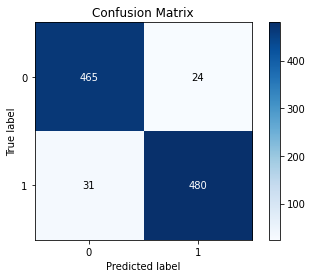

In [70]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.86396061908139
acc: 0.86956


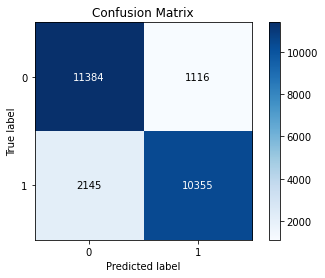

In [71]:
predict_result(model, test_x, test_y)

# Feature 1 (TF-IDF)

In [6]:
def get_tfidf_vector_and_one_hot(df):
    x = tfidf_vectorizer.transform(df['text'].values).todense()
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [51]:
train_val_x, train_val_y = get_tfidf_vector_and_one_hot(train_df)
test_x, test_y = get_tfidf_vector_and_one_hot(test_df)

In [52]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 1 (FFNN w TF-IDF)

In [ ]:
model = Sequential([
    Dense(64, input_shape=(train_x.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_tfidf_ffnn/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

In [58]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
607/625 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9354
Epoch 1: val_accuracy did not improve from 0.89100
625/625 [==============================] - 2s 3ms/step - loss: 0.1731 - accuracy: 0.9352 - val_loss: 0.2951 - val_accuracy: 0.8874
Epoch 2/50
619/625 [============================>.] - ETA: 0s - loss: 0.0937 - accuracy: 0.9666
Epoch 2: val_accuracy did not improve from 0.89100
625/625 [==============================] - 2s 2ms/step - loss: 0.0942 - accuracy: 0.9664 - val_loss: 0.3586 - val_accuracy: 0.8814
Epoch 3/50
609/625 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.9865
Epoch 3: val_accuracy did not improve from 0.89100
625/625 [==============================] - 2s 2ms/step - loss: 0.0419 - accuracy: 0.9865 - val_loss: 0.5274 - val_accuracy: 0.8812
Epoch 4/50
623/625 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9937
Epoch 4: val_accuracy did not improve from 0.89100
625/625 [==========

In [59]:
model.load_weights('./models_tfidf_ffnn/checkpoint')

f1 : 0.9585342333654773
acc: 0.957


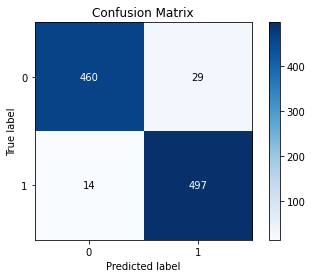

In [60]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8708578755459392
acc: 0.87108


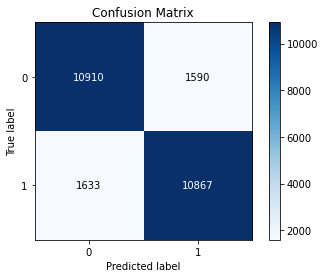

In [61]:
predict_result(model, test_x, test_y)

# Feature 2 (Spacy document vector)

In [14]:
def get_spacy_vector_and_one_hot(df):
    text_list = df['text'].to_list()
    x = []
    for doc in tqdm_notebook(nlp.pipe(text_list, disable=["tagger", "parser", "lemmatizer", 'attribute_ruler', 'ner']),total=len(text_list) ):
        x.append(doc.vector)
    x = pd.DataFrame(x)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [15]:
train_val_x, train_val_y = get_spacy_vector_and_one_hot(train_df)
test_x, test_y = get_spacy_vector_and_one_hot(test_df)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

# Splitting training data into train and validation set

In [16]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 2 (FFNN w Spacy Doc Vector)

In [17]:
model = Sequential([
    Dense(512, input_shape=(300,), activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_spacy_ffnn/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               154112    
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 1,205,250
Trainable params: 1,205,250
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=32,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
612/625 [============================>.] - ETA: 0s - loss: 0.3985 - accuracy: 0.8200
Epoch 1: val_accuracy improved from -inf to 0.84920, saving model to ./models_spacy_ffnn\checkpoint
625/625 [==============================] - 2s 3ms/step - loss: 0.3982 - accuracy: 0.8199 - val_loss: 0.3529 - val_accuracy: 0.8492
Epoch 2/50
611/625 [============================>.] - ETA: 0s - loss: 0.3532 - accuracy: 0.8489
Epoch 2: val_accuracy did not improve from 0.84920
625/625 [==============================] - 1s 2ms/step - loss: 0.3540 - accuracy: 0.8484 - val_loss: 0.3646 - val_accuracy: 0.8422
Epoch 3/50
615/625 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8532
Epoch 3: val_accuracy did not improve from 0.84920
625/625 [==============================] - 1s 2ms/step - loss: 0.3418 - accuracy: 0.8530 - val_loss: 0.3580 - val_accuracy: 0.8388
Epoch 4/50
609/625 [============================>.] - ETA: 0s - loss: 0.3302 - accuracy: 0.8573
Epoch 4: val_accuracy

Epoch 30/50
610/625 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9753
Epoch 30: val_accuracy did not improve from 0.85860
625/625 [==============================] - 1s 2ms/step - loss: 0.0650 - accuracy: 0.9755 - val_loss: 0.8401 - val_accuracy: 0.8460
Epoch 31/50
623/625 [============================>.] - ETA: 0s - loss: 0.0582 - accuracy: 0.9790
Epoch 31: val_accuracy did not improve from 0.85860
625/625 [==============================] - 1s 2ms/step - loss: 0.0585 - accuracy: 0.9789 - val_loss: 0.8343 - val_accuracy: 0.8344
Epoch 32/50
605/625 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9780
Epoch 32: val_accuracy did not improve from 0.85860
625/625 [==============================] - 1s 2ms/step - loss: 0.0579 - accuracy: 0.9779 - val_loss: 0.7585 - val_accuracy: 0.8410
Epoch 33/50
596/625 [===========================>..] - ETA: 0s - loss: 0.0575 - accuracy: 0.9789
Epoch 33: val_accuracy did not improve from 0.85860
625/625 [==

In [19]:
model.load_weights('./models_spacy_ffnn/checkpoint')

f1 : 0.8880382775119617
acc: 0.883


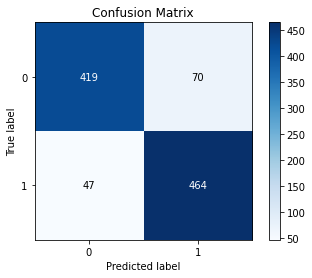

In [20]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8542562847784049
acc: 0.85228


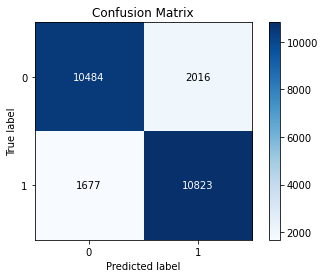

In [21]:
predict_result(model, test_x, test_y)

# Feature 3 (Text to Sequences)

In [72]:
def get_sequences_and_one_hot(df):
    sequences = tokenizer.texts_to_sequences(df['text'].values)
    x = pad_sequences(sequences, maxlen=max_words)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [73]:
train_val_x, train_val_y = get_sequences_and_one_hot(train_df)
test_x, test_y = get_sequences_and_one_hot(test_df)

In [74]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 3 (LSTM)

In [76]:
model = Sequential([
    Embedding(512, embedding_size, input_length=max_words),
    LSTM(512),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_t2s_lstm/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 300)          153600    
                                                                 
 lstm_4 (LSTM)               (None, 512)               1665024   
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                32832     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1,851,586
Trainable params: 1,851,586
No

In [77]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=256,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
78/79 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5917
Epoch 1: val_accuracy improved from -inf to 0.61580, saving model to ./models_t2s_lstm\checkpoint
79/79 [==============================] - 11s 131ms/step - loss: 0.6842 - accuracy: 0.5917 - val_loss: 0.6483 - val_accuracy: 0.6158
Epoch 2/50
78/79 [============================>.] - ETA: 0s - loss: 0.5121 - accuracy: 0.7472
Epoch 2: val_accuracy improved from 0.61580 to 0.80560, saving model to ./models_t2s_lstm\checkpoint
79/79 [==============================] - 10s 129ms/step - loss: 0.5124 - accuracy: 0.7470 - val_loss: 0.4337 - val_accuracy: 0.8056
Epoch 3/50
78/79 [============================>.] - ETA: 0s - loss: 0.4057 - accuracy: 0.8242
Epoch 3: val_accuracy improved from 0.80560 to 0.80820, saving model to ./models_t2s_lstm\checkpoint
79/79 [==============================] - 10s 131ms/step - loss: 0.4060 - accuracy: 0.8240 - val_loss: 0.4243 - val_accuracy: 0.8082
Epoch 4/50
78/79 [====

Epoch 30/50
78/79 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9208
Epoch 30: val_accuracy did not improve from 0.83600
79/79 [==============================] - 10s 125ms/step - loss: 0.1768 - accuracy: 0.9207 - val_loss: 0.6990 - val_accuracy: 0.7946
Epoch 31/50
78/79 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9179
Epoch 31: val_accuracy did not improve from 0.83600
79/79 [==============================] - 10s 125ms/step - loss: 0.1930 - accuracy: 0.9179 - val_loss: 0.6258 - val_accuracy: 0.7982
Epoch 32/50
78/79 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9256
Epoch 32: val_accuracy did not improve from 0.83600
79/79 [==============================] - 10s 125ms/step - loss: 0.1667 - accuracy: 0.9256 - val_loss: 0.7235 - val_accuracy: 0.7972
Epoch 33/50
78/79 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.9310
Epoch 33: val_accuracy did not improve from 0.83600
79/79 [=========

In [78]:
model.load_weights('./models_t2s_lstm/checkpoint')

f1 : 0.8557504873294347
acc: 0.852


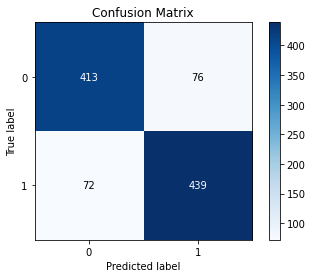

In [79]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8371132382730271
acc: 0.83596


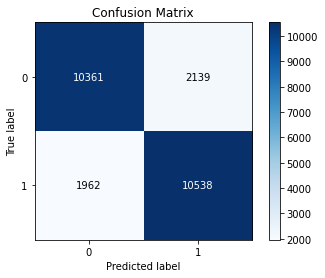

In [80]:
predict_result(model, test_x, test_y)

# Model 4 (Bi-LSTM)

In [30]:
model = Sequential([
    Embedding(512, embedding_size, input_length=max_words),
    Bidirectional(LSTM(256)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_t2s_bilstm/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          76800     
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1140736   
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                      

In [31]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
156/157 [============================>.] - ETA: 0s - loss: 0.6094 - accuracy: 0.6607
Epoch 1: val_accuracy improved from -inf to 0.76120, saving model to ./models_t2s_bilstm\checkpoint
157/157 [==============================] - 11s 62ms/step - loss: 0.6092 - accuracy: 0.6608 - val_loss: 0.5048 - val_accuracy: 0.7612
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.7742
Epoch 2: val_accuracy improved from 0.76120 to 0.77400, saving model to ./models_t2s_bilstm\checkpoint
157/157 [==============================] - 9s 60ms/step - loss: 0.4930 - accuracy: 0.7742 - val_loss: 0.4748 - val_accuracy: 0.7740
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7797
Epoch 3: val_accuracy did not improve from 0.77400
157/157 [==============================] - 9s 54ms/step - loss: 0.4758 - accuracy: 0.7797 - val_loss: 0.4682 - val_accuracy: 0.7718
Epoch 4/50
157/157 [==============================] - ETA: 0s

In [32]:
model.load_weights('./models_t2s_bilstm/checkpoint')

f1 : 0.8599221789883268
acc: 0.856


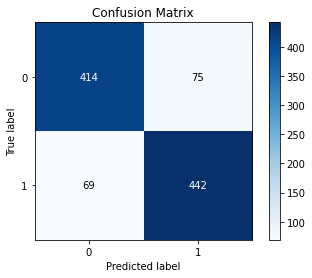

In [33]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.7918560980430916
acc: 0.7894


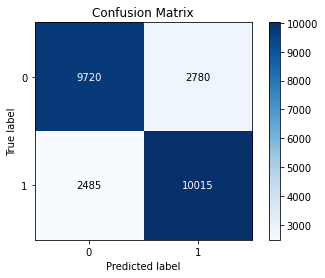

In [34]:
predict_result(model, test_x, test_y)

# Feature 3 (Glove Embeddings)

In [35]:
path = './glove.42B.300d/glove.42B.300d.txt'

embeddings_index = {}

with open(path, encoding='utf8') as f:
    for line in tqdm_notebook(f):
        word, coef = line.split(maxsplit=1)
        coef = np.fromstring(coef, 'f', sep=' ')
        embeddings_index[word] = coef
        
len(embeddings_index)

0it [00:00, ?it/s]

1917494

In [36]:
embedding_dim = 300

num_tokens = len(vocab) + 2

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None :
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18943 words (1057 misses)


In [37]:
def get_vector_and_one_hot(df):
    x = vectorizer(np.array([[s] for s in tqdm_notebook(df['text'])])).numpy() 
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

In [38]:
train_val_x, train_val_y = get_vector_and_one_hot(train_df)
test_x, test_y = get_vector_and_one_hot(test_df)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [39]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

# Model 4 

In [41]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Dense(256, activation="relu")(embedded_sequences)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

preds = Dense(2, activation="sigmoid")(x)

model = tf.keras.Model(int_sequences_input, preds)

callbacks=[
    ModelCheckpoint(filepath='./models_glove_ffnn/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 300)         6000600   
                                                                 
 dense_17 (Dense)            (None, None, 256)         77056     
                                                                 
 dropout_10 (Dropout)        (None, None, 256)         0         
                                                                 
 dense_18 (Dense)            (None, None, 256)         65792     
                                                                 
 dropout_11 (Dropout)        (None, None, 256)         0         
                                                                 
 dense_19 (Dense)            (None, None, 256)         6579

In [42]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
156/157 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.7044
Epoch 1: val_accuracy improved from -inf to 0.77020, saving model to ./models_glove_ffnn\checkpoint
157/157 [==============================] - 3s 16ms/step - loss: 0.5415 - accuracy: 0.7046 - val_loss: 0.4849 - val_accuracy: 0.7702
Epoch 2/50
156/157 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8321
Epoch 2: val_accuracy did not improve from 0.77020
157/157 [==============================] - 2s 13ms/step - loss: 0.3776 - accuracy: 0.8320 - val_loss: 0.5199 - val_accuracy: 0.7196
Epoch 3/50
156/157 [============================>.] - ETA: 0s - loss: 0.3530 - accuracy: 0.8482
Epoch 3: val_accuracy improved from 0.77020 to 0.77480, saving model to ./models_glove_ffnn\checkpoint
157/157 [==============================] - 2s 15ms/step - loss: 0.3531 - accuracy: 0.8481 - val_loss: 0.4896 - val_accuracy: 0.7748
Epoch 4/50
156/157 [============================>.] - ETA: 0s 

In [43]:
model.load_weights('./models_glove_ffnn/checkpoint')

f1 : 0.937691521961185
acc: 0.939


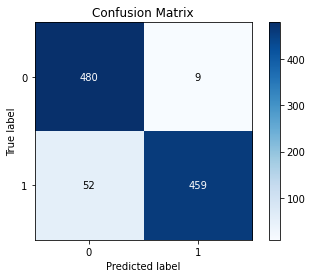

In [44]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.7940058543405129
acc: 0.8114


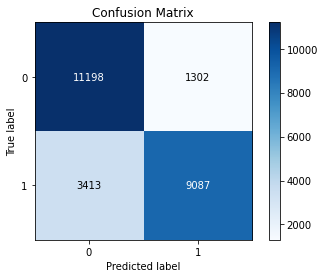

In [45]:
predict_result(model, test_x, test_y)

In [46]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Bidirectional(LSTM(128))(embedded_sequences)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Flatten()(x)

preds = Dense(2, activation="sigmoid")(x)

model = tf.keras.Model(int_sequences_input, preds)

callbacks=[
    ModelCheckpoint(filepath='./models_glove_bilstm/checkpoint',
                   save_best_only=True, save_weights_only=True, verbose=1,monitor='val_accuracy')
]

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 300)         6000600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                           

In [47]:
model.compile('adam', loss=BinaryCrossentropy(), metrics='accuracy')

model.fit(x=train_x,
         y=train_y,
         batch_size=128,
         epochs=50,
         validation_data=(val_x, val_y),
         callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7479
Epoch 1: val_accuracy improved from -inf to 0.82260, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 10s 52ms/step - loss: 0.5362 - accuracy: 0.7479 - val_loss: 0.4366 - val_accuracy: 0.8226
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8235
Epoch 2: val_accuracy improved from 0.82260 to 0.83480, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 8s 49ms/step - loss: 0.4121 - accuracy: 0.8235 - val_loss: 0.3910 - val_accuracy: 0.8348
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8507
Epoch 3: val_accuracy improved from 0.83480 to 0.84640, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 7s 45ms/step - loss: 0.3585 - accuracy: 0.8507 - val_loss: 0.3635 - val_accuracy: 0.8464
Epo

157/157 [==============================] - 7s 47ms/step - loss: 0.0298 - accuracy: 0.9901 - val_loss: 0.6045 - val_accuracy: 0.8686
Epoch 29/50
157/157 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9974
Epoch 29: val_accuracy improved from 0.87860 to 0.87920, saving model to ./models_glove_bilstm\checkpoint
157/157 [==============================] - 8s 49ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.8698 - val_accuracy: 0.8792
Epoch 30/50
157/157 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9969
Epoch 30: val_accuracy did not improve from 0.87920
157/157 [==============================] - 7s 45ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.8029 - val_accuracy: 0.8648
Epoch 31/50
157/157 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9923
Epoch 31: val_accuracy did not improve from 0.87920
157/157 [==============================] - 7s 44ms/step - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0

In [48]:
model.load_weights('./models_glove_bilstm/checkpoint')

f1 : 0.9990224828934506
acc: 0.999


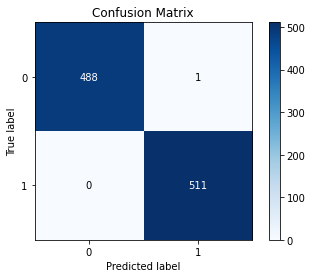

In [49]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8758346520514108
acc: 0.87132


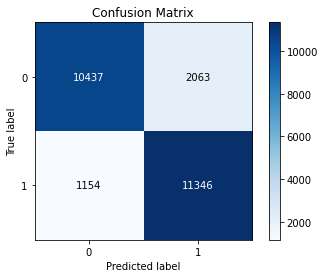

In [50]:
predict_result(model, test_x, test_y)